# STM Transit Delay Feature Engineering and Data Preprocessing

This notebook preprocesses data about STM trip updates and weather data in order to build a tree-based regression model that predicts delays in seconds.

## Data Description

`current_time` timestamp when the data was collected<br>
`trip_id` unique identifier of a trip<br>
`vehicle_id` unique identifier of a vehicle<br>
`vehicle_stop_status` vehicle stop status<br>
`occupancy_status` degree of passenger occupancy<br>
`route_id` bus or metro line<br>
`stop_id` stop number<br>
`stop_lat`stop latitude<br>
`stop_lon`stop longitude<br>
`stop_sequence` sequence of the stop, for ordering<br>
`wheelchair_boarding` indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false<br>
`realtime_arrival_time` actual arrival time, in milliseconds<br>
`scheduled_arrival_time` planned arrival time, in milliseconds<br>
`temperature` air temperature at 2 meters above ground, in Celsius<br>
`precipitation` total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters<br>
`windspeed` wind speed at 10 meters above ground, in km/h<br>
`weathercode` World Meteorological Organization (WMO) code<br>
`incident_nearby`indicates if an incident happened within 1km when the vehicle arrived at the stop<br>
`incident_category` category of incident

## Imports

In [32]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
import sys

In [ ]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import LOCAL_TIMEZONE, WEATHER_CODES

In [3]:
# Load data
df = pd.read_csv('../data/stm_weather_merged.csv')

## Feature Engineering

### Delay

In [4]:
# Convert real and scheduled timestamps
df['realtime_arrival_time'] = pd.to_datetime(df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
df['scheduled_arrival_time'] = pd.to_datetime(df['scheduled_arrival_time'], origin='unix', unit='ms', utc=True)

In [5]:
# Calculate delay in seconds (real - scheduled)
df['delay'] = (df['realtime_arrival_time'] - df['scheduled_arrival_time']).dt.total_seconds()

In [6]:
# Convert arrival times to local timezone
df['realtime_arrival_time'] = df['realtime_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df['scheduled_arrival_time'] = df['scheduled_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)

In [7]:
# Get distribution
df['delay'].describe()

count    2.087922e+06
mean     6.344688e+01
std      3.675095e+02
min     -8.377000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      9.000000e+00
max      3.464900e+04
Name: delay, dtype: float64

In [8]:
# Get proportion of trips that are on time
on_time_mask = df['delay'] == 0
print(f'{(on_time_mask.sum() / len(df)):.2%}')

72.21%


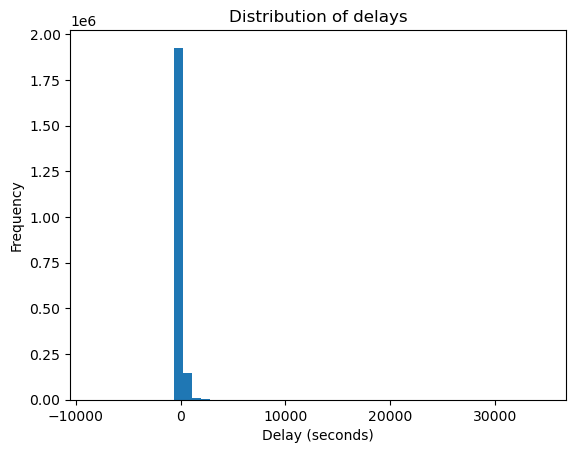

In [9]:
# Plot distribution of delays
plt.hist(df['delay'], bins=50)
plt.title('Distribution of delays')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_hist.png', bbox_inches='tight')
plt.show()

The plot shows there are some massive delays (~2h15min early to ~9h30min late), which could greatly affect the model performance. It's probably due to data error.

### Trip Progress

In [17]:
# Sort values by stop sequence
df = df.sort_values(by=['trip_id', 'route_id', 'stop_sequence'])

In [18]:
# Reset stop sequences (some stops are missing)
df['stop_sequence'] = df.groupby(['trip_id', 'route_id']).cumcount() + 1

In [19]:
# Calculate trip progress percentage
total_stops = df.groupby(['trip_id', 'route_id'])['stop_id'].transform('count')
df['trip_progress_pct'] = df['stop_sequence'] / total_stops

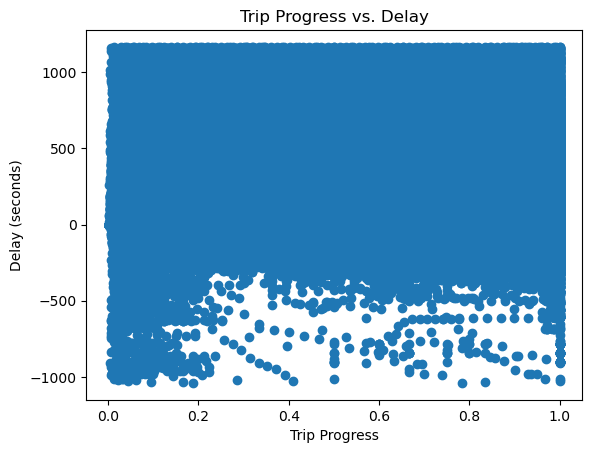

In [20]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress_pct'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/trip_progress_vs_delay.png', bbox_inches='tight')
plt.show()

From the plot, it looks like the delay is relatively stable across the trip progress. There are many data points that appear scattered around the x-axis, indicating that delays do not change significantly throughout the trip in many cases. The wide range of delays suggests that delays are highly variable, but there is not clear relationship between trip progress and delay. The could imply that other factors like traffic, accidents, mechanical issues or weather may have more impact on the delays.

### Past Data vs. Training Data

The dataset only has data from {April 23th} to {April 27th}. In order to calculate the historical delay without having data leakage, the data needs to be separated in two, based on the time it was collected. Therefore, the training data for the regression model will be on the more recent data.

In [ ]:
# Convert datetime to day and hour
df['day'] = df['realtime_arrival_time'].dt.day_of_week
df['hour'] = df['realtime_arrival_time'].dt.hour

In [ ]:
# Order dataframe by the time the data was collected
df = df.sort_values(by='current_time')

In [ ]:
# Split dataset in two
index = math.floor(len(df) / 2)
past_data = df.iloc[:index, :]
new_data = df.iloc[index:, :]

### Handle Outliers

In [ ]:
# Compute mean and standard deviation TODO: create function for both datasets
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [ ]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [ ]:
# Get outliers
outliers = df[outlier_mask]

In [ ]:
# Get proportion of outliers
print(f'{(outlier_mask.sum() / len(df)):.2%}')

In [ ]:
# Remove outliers
df = df[~outlier_mask]

In [ ]:
# Get new distribution
df['delay'].describe()

### Historical Delay

In [35]:
# Get average delay by stop, day and hour
stop_hour_avg_delay = past_data.groupby(['stop_id', 'day', 'hour'])['delay'].mean().reset_index()
stop_hour_avg_delay = stop_hour_avg_delay.rename(columns={'delay': 'historical_avg_delay'})
past_data = past_data.merge(stop_hour_avg_delay, on=['stop_id', 'day', 'hour'], how='left')

In [ ]:
# Plot historical delay vs real delay
plt.scatter(x=df['historical_avg_delay'], y=df['delay'])
plt.title('Historical Delay vs. Real Delay')
plt.xlabel('Historical Delay (seconds)')
plt.ylabel('Real Delay (seconds)')
plt.savefig('../images/hist_vs_real_delay.png', bbox_inches='tight')
plt.show()

The plot shows a positive correlation between historical delays and real delays, but the relationship seems noisy. The clusters and digonal pattern suggest that if is a significant delay historically, it is likely to be reflected in the current delay, although it's not perfectly clear. Some points could indicate extreme cases where the delay trends diverge. For example, some trips might recover from past delays or worsen unexpectedly.

## Data Preprocessing

### Encode Datetime

In [ ]:
# Get day and hour from scheduled time
df['sch_day'] = df['scheduled_arrival_time'].dt.day_of_week
df['sch_hour'] = df['scheduled_arrival_time'].dt.hour

In [ ]:
# Use Cyclical Encoding for day and hour, as it's more suitable for time-related features
# And the model can "understand" the wrap-around
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)

df['sch_day_sin'] = np.sin(2 * np.pi * df['sch_day'] / 7)
df['sch_day_cos'] = np.cos(2 * np.pi * df['sch_day'] / 7)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['sch_hour_sin'] = np.sin(2 * np.pi * df['sch_hour'] / 24)
df['sch_hour_cos'] = np.cos(2 * np.pi * df['sch_hour'] / 24)

In [ ]:
# Add boolean value is_weekend
weekend_mask = df['day'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [ ]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

### Use Label Encoding for route_id and stop_id

In [ ]:
le_route = LabelEncoder()
df['route_id'] = le_route.fit_transform(df['route_id'])

In [ ]:
le_stop = LabelEncoder()
df['stop_id'] = le_stop.fit_transform(df['stop_id'])

### Convert weathercode Into Categories

In [ ]:
# Create weather code mapping
weathercodes = df['weathercode'].sort_values().unique()
condition_list = []
label_list = []

for code in weathercodes:
  condition_list.append(df['weathercode'] == code)
  label_list.append(WEATHER_CODES[code])

In [ ]:
# Create categories
df['weather'] = np.select(condition_list, label_list, default='Unknown')

In [ ]:
df['weather'].value_counts()

In [ ]:
# Collapsing categories to 6 max
df['weather'] = np.where(df['weather'].isin(['Light drizzle', 'Moderate drizzle', 'Dense drizzle']), 'Drizzle', df['weather'])
df['weather'] = np.where(df['weather'].isin(['Slight rain', 'Moderate rain']), 'Rain', df['weather'])
df['weather'].value_counts()

In [ ]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['weather'], drop_first=True, dtype='int64', prefix='weather')
df = df.drop(['weathercode', 'weather'], axis=1).join(one_hot)

## Export Data

In [ ]:
df.columns

In [ ]:
# Keep encoded columns and reorder them
df = df[['route_id', 'stop_id', 'pca_coords', 'stop_sequence', 'trip_progress_pct',
  		'wheelchair_boarding', 'day_sin', 'day_cos', 'sch_day_sin', 'sch_day_cos', 'hour_sin', 'hour_cos', 
  		'sch_hour_sin', 'sch_hour_cos', 'is_weekend', 'is_peak_hour', 'historical_avg_delay', 'delay_was_clipped',
  		'temperature', 'precipitation', 'windspeed', 'weather_Drizzle',
       'weather_Mainly clear', 'weather_Overcast', 'weather_Partly cloudy',
       'weather_Slight rain' , 'delay']]

In [ ]:
# Export encoders
encoders = {
  'le_route': le_route,
  'le_stop': le_stop
}
with open('../models/label_encoders.pickle', 'wb') as handle:
	pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
df.info()

In [ ]:
# Export dataframe
df.to_csv('../data/preprocessed.csv', index=False)

## End